<h1>Tracking the spread of 2019 Coronavirus</h1>

<img src="https://storage.googleapis.com/kaggle-datasets-images/544069/992803/500beb47c451ac68fae29a8eb95ae45c/dataset-card.jpg" width=400></img>

# Introduction

The 2019-nCoV is a highly contagious coronavirus that originated from Wuhan (Hubei province), Mainland China. This new strain of virus has striked fear in many countries as cities are quarantined and hospitals are overcrowded.

We are using here a Kaggle Dataset [Coronavirus 2019-nCoV](https://www.kaggle.com/gpreda/coronavirus-2019ncov) updated daily, based on [John Hopkins data](https://github.com/CSSEGISandData/COVID-19/). 

The Kernel will be rerun frequently to reflect the daily evolution of the cited dataset.

We start by analyzing the data for Mainland China, where the pandemic originated. We show time evolutions and snapshots of Confirmed, Recovered cases as well as Deaths. Then we move to explore the evolution of the pandemics in the rest of the World.

For both Mainland China and the rest of the World we are also showing the snapshot and time evolution of mortality, calculated in two ways: as Deaths / Confirmed cases (most probably a underestimate) and as Deaths / Recovered cases (most probably an overestimate).


In [1]:
import datetime as dt
dt_string = dt.datetime.now().strftime("%d/%m/%Y")
print(f"Kernel last updated: {dt_string}")

Kernel last updated: 18/03/2020


# Analysis preparation

## Load packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import folium
from folium.plugins import HeatMap, HeatMapWithTime
%matplotlib inline

## Load the data

There are multiple files in the coronavirus data folder, we will take the last updated one.
We also include GeoJSON data for China and for World.

In [3]:
print(os.listdir('/kaggle/input'))
DATA_FOLDER = "/kaggle/input/coronavirus-2019ncov"
print(os.listdir(DATA_FOLDER))
GEO_DATA = "/kaggle/input/china-regions-map"
print(os.listdir(GEO_DATA))
WD_GEO_DATA = '/kaggle/input/python-folio-country-boundaries'
print(os.listdir(WD_GEO_DATA))

['python-folio-country-boundaries', 'coronavirus-2019ncov', 'china-regions-map']
['covid-19-all.csv']
['china-provinces.json', 'china.json']
['world-countries.json']


In [4]:
data_df = pd.read_csv(os.path.join(DATA_FOLDER, "covid-19-all.csv"))
cn_geo_data = os.path.join(GEO_DATA, "china.json")
wd_geo_data = os.path.join(WD_GEO_DATA, "world-countries.json")

# Preliminary data exploration

## Glimpse the data

We check data shape, we look to few rows of the data, we check for missing data.

In [5]:
print(f"Rows: {data_df.shape[0]}, Columns: {data_df.shape[1]}")

Rows: 6438, Columns: 8


In [6]:
data_df.head()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,Mainland China,Anhui,31.8257,117.2264,1.0,NaN,NaN,2020-01-22
1,Mainland China,Beijing,40.1824,116.4142,14.0,NaN,NaN,2020-01-22
2,Mainland China,Chongqing,30.0572,107.8740,6.0,NaN,NaN,2020-01-22
3,Mainland China,Fujian,26.0789,117.9874,1.0,NaN,NaN,2020-01-22
4,Mainland China,Gansu,36.0611,103.8343,NaN,NaN,NaN,2020-01-22


In [7]:
data_df.tail()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
6433,Guernsey,NaN,49.4500,-2.5800,0.0,0.0,0.0,2020-03-17
6434,Jersey,NaN,49.1900,-2.1100,0.0,0.0,0.0,2020-03-17
6435,Puerto Rico,NaN,18.2000,-66.5000,0.0,0.0,0.0,2020-03-17
6436,Republic of the Congo,NaN,-1.4400,15.5560,0.0,0.0,0.0,2020-03-17
6437,occupied Palestinian territory,NaN,31.9522,35.2332,0.0,0.0,0.0,2020-03-17


In [8]:
for column in data_df.columns:
    print(f"{column}:{data_df[column].dtype}")

Country/Region:object
Province/State:object
Latitude:float64
Longitude:float64
Confirmed:float64
Recovered:float64
Deaths:float64
Date:object


In [9]:
print(f"Date - unique values: {data_df['Date'].nunique()} ({min(data_df['Date'])} - {max(data_df['Date'])})")

Date - unique values: 56 (2020-01-22 - 2020-03-17)


In [10]:
data_df['Date'] = pd.to_datetime(data_df['Date'])

In [11]:
for column in data_df.columns:
    print(f"{column}:{data_df[column].dtype}")

Country/Region:object
Province/State:object
Latitude:float64
Longitude:float64
Confirmed:float64
Recovered:float64
Deaths:float64
Date:datetime64[ns]


In [12]:
print(f"Date - unique values: {data_df['Date'].nunique()} ({min(data_df['Date'])} - {max(data_df['Date'])})")

Date - unique values: 56 (2020-01-22 00:00:00 - 2020-03-17 00:00:00)


In [13]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

Let's look to the missing values.

In [14]:
missing_data(data_df)

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
Total,0,2612,1,1,19,388,441,0
Percent,0,40.5716,0.0155328,0.0155328,0.295123,6.02672,6.84995,0
Types,object,object,float64,float64,float64,float64,float64,datetime64[ns]


Let's check the spread of the 2019-nCoV in various Regions/Countries and Provinces/States.

In [15]:
print(f"Countries/Regions:{data_df['Country/Region'].nunique()}")
print(f"Province/State:{data_df['Province/State'].nunique()}")

Countries/Regions:180
Province/State:273


## Load geo data

Let's check the GeoJSON data first.

In [16]:
ch_map = folium.Map(location=[35, 100], zoom_start=4)

folium.GeoJson(
    cn_geo_data,
    name='geojson'
).add_to(ch_map)

folium.LayerControl().add_to(ch_map)

ch_map

In [17]:
wd_map = folium.Map(location=[0,0], zoom_start=2)

folium.GeoJson(
    wd_geo_data,
    name='geojson'
).add_to(wd_map)

folium.LayerControl().add_to(wd_map)

wd_map

# Mainland China

We start by exploring the data in Mainland China, where the epidemics first apeared.   

Let's group the data from China on `Province/State`.

In [18]:
data_cn = data_df.loc[data_df['Country/Region']=="Mainland China"]
data_cn = data_cn.sort_values(by = ['Province/State','Date'], ascending=False)

We will show the last updated values for confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China.

In [19]:
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'],keep='first')

In [20]:
def plot_count(feature, value, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    g = sns.barplot(df[feature], df[value], palette='Set3')
    g.set_title("Number of {}".format(title))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()    

## Mainland China - total cases

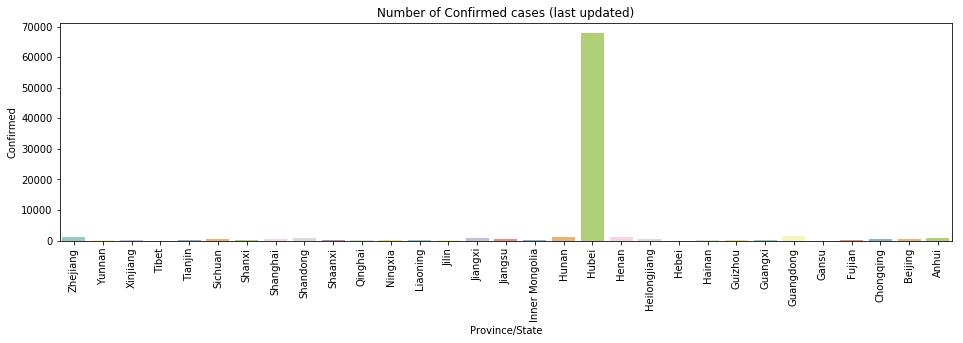

In [21]:
plot_count('Province/State', 'Confirmed', 'Confirmed cases (last updated)', filtered_data_last, size=4)

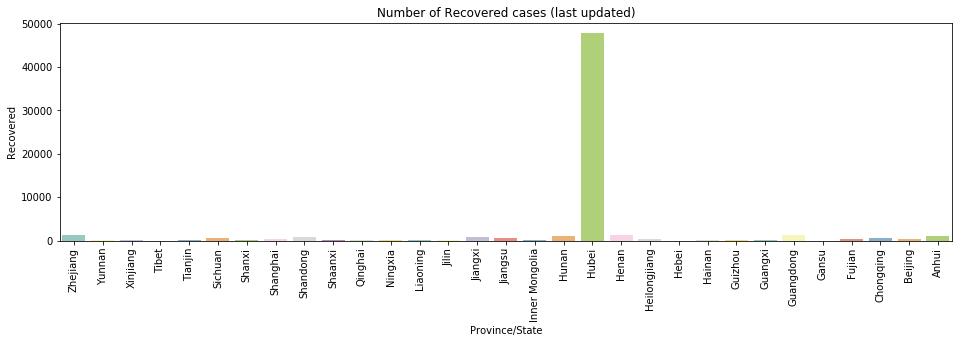

In [22]:
plot_count('Province/State', 'Recovered', 'Recovered cases (last updated)', filtered_data_last, size=4)

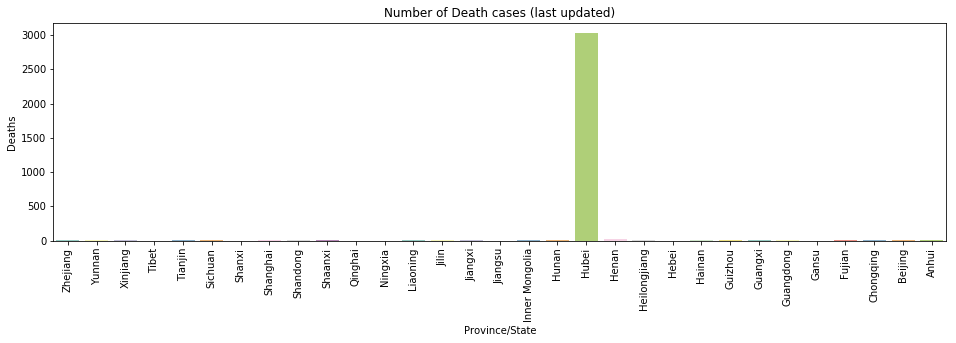

In [23]:
plot_count('Province/State', 'Deaths', 'Death cases (last updated)', filtered_data_last, size=4)

Now we will show again the confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China, as evolved in time.

In [24]:
def plot_time_variation(df, y='Confirmed', hue='Province/State', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x="Date", y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    plt.title(f'{y} cases grouped by {hue}')
    plt.show()  

## Mainland China - time evolution

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


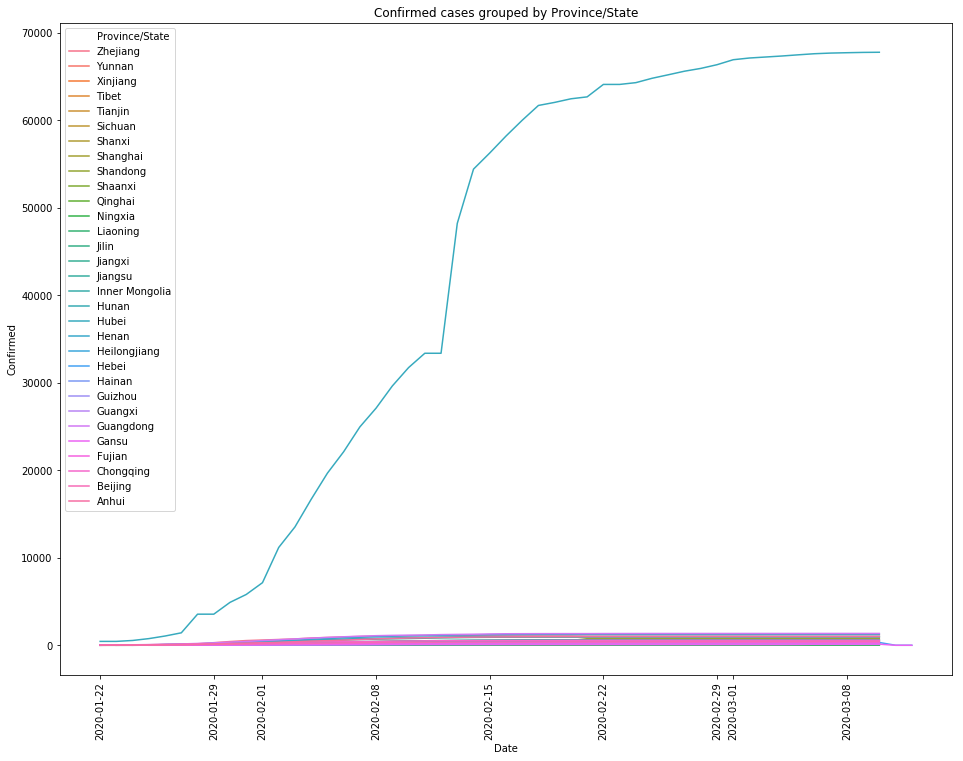

In [25]:
plot_time_variation(data_cn, size=4)

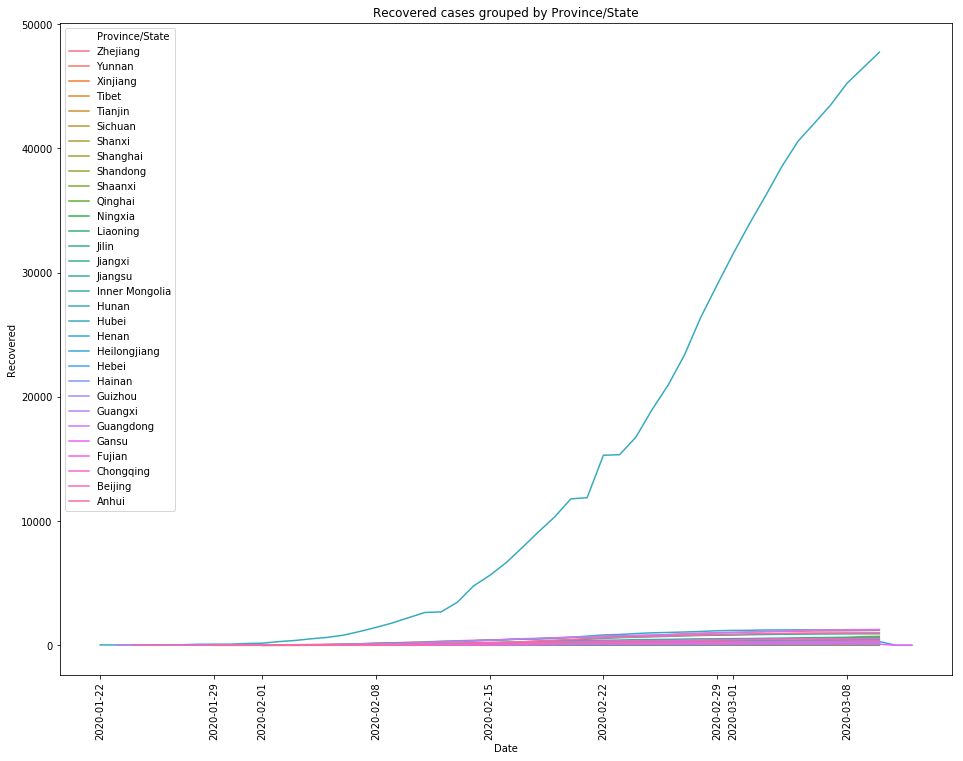

In [26]:
plot_time_variation(data_cn, y='Recovered', size=4)

## Mainland China - overall

Let's compare overall values for Mainland China (Confirmed, Recovered, Deaths).


In [27]:
def plot_time_variation_all(df, title='Mainland China', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.lineplot(x="Date", y='Confirmed', data=df, color='blue', label='Confirmed')
    g = sns.lineplot(x="Date", y='Recovered', data=df, color='green', label='Recovered')
    g = sns.lineplot(x="Date", y='Deaths', data=df, color = 'red', label = 'Deaths')
    plt.xlabel('Date')
    plt.ylabel(f'Total {title} cases')
    plt.xticks(rotation=90)
    plt.title(f'Total {title} cases')
    plt.show()  


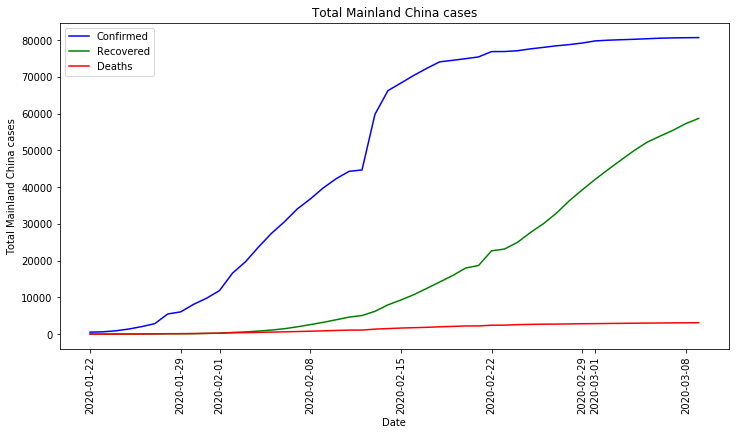

In [28]:
data_cn = data_cn.loc[data_cn['Date']<'2020-03-10']
data_cn_agg = data_cn.groupby(['Date']).sum().reset_index()
plot_time_variation_all(data_cn_agg, size=3)

## Mainland China (except Hubei) - time evolution

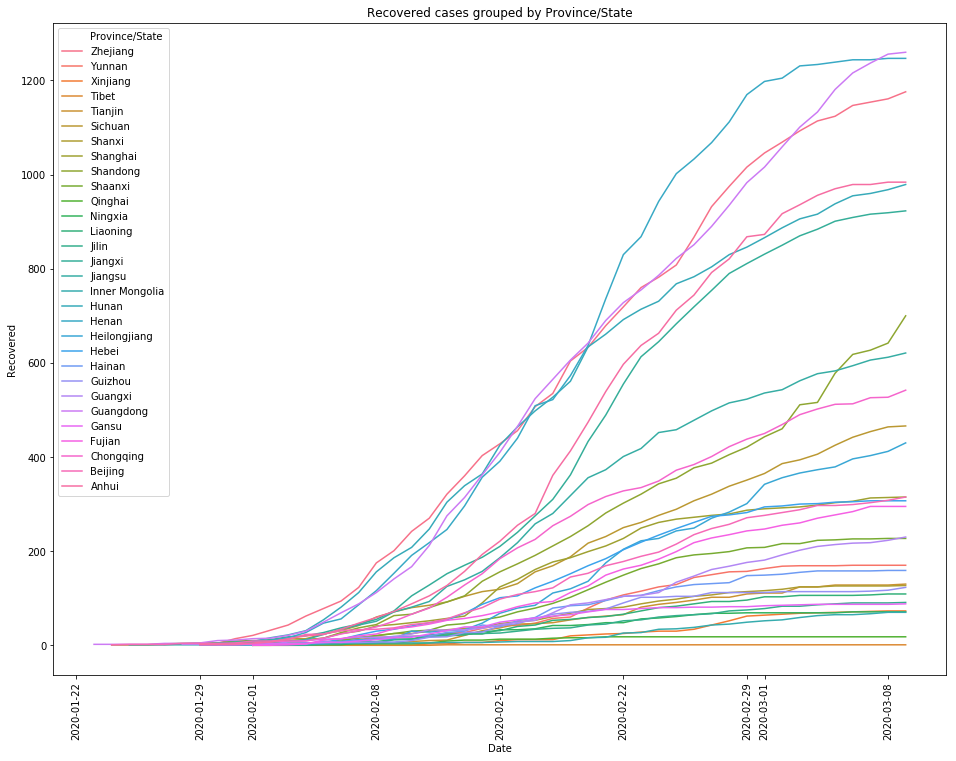

In [29]:
filtered_data_last = filtered_data_last.reset_index()
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')],y='Recovered', size=4)

The following Folium group using **CircleMarker** is created using the inspiration from: https://www.kaggle.com/grebublin/coronavirus-propagation-visualization-forecast Kernel.

In [30]:
m = folium.Map(location=[30, 100], zoom_start=4)

folium.Choropleth(
    geo_data=cn_geo_data,
    name='Confirmed cases - regions',
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.05,
    line_opacity=0.3,
).add_to(m)

radius_min = 2
radius_max = 40
weight = 1
fill_opacity = 0.2

_color_conf = 'red'
group0 = folium.FeatureGroup(name='<span style=\\"color: #EFEFE8FF;\\">Confirmed cases</span>')
for i in range(len(filtered_data_last)):
    lat = filtered_data_last.loc[i, 'Latitude']
    lon = filtered_data_last.loc[i, 'Longitude']
    province = filtered_data_last.loc[i, 'Province/State']
    recovered = filtered_data_last.loc[i, 'Recovered']
    death = filtered_data_last.loc[i, 'Deaths']

    _radius_conf = np.sqrt(filtered_data_last.loc[i, 'Confirmed'])
    if _radius_conf < radius_min:
        _radius_conf = radius_min

    if _radius_conf > radius_max:
        _radius_conf = radius_max

    _popup_conf = str(province) + '\n(Confirmed='+str(filtered_data_last.loc[i, 'Confirmed']) + '\nDeaths=' + str(death) + '\nRecovered=' + str(recovered) + ')'
    folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_conf, 
                        popup = _popup_conf, 
                        color = _color_conf, 
                        fill_opacity = fill_opacity,
                        weight = weight, 
                        fill = True, 
                        fillColor = _color_conf).add_to(group0)

group0.add_to(m)
folium.LayerControl().add_to(m)
m

## Mainland China - mortality


Let's plot the mortality in two ways. We will calculate the mortality as percent of Deaths from the Confirmed cases and also will calculate the mortality as a percent from the Recovered cases. The first one is an underestimate, since death will happen typically at least few days after a case is confirmed. The second one is an overestimate, since death will most probably occur much faster than a recovery. But we plot both to have both estimation and most probably the real mortality is in between. 

In [31]:
def plot_time_variation_mortality(df, title='Mainland China', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.lineplot(x="Date", y='Mortality (D/C)', data=df, color='blue', label='Mortality (Deaths / Confirmed)')
    g = sns.lineplot(x="Date", y='Mortality (D/R)', data=df, color='green', label='Mortality (Death / Recovered)')
    plt.xlabel('Date')
    ax.set_yscale('log')
    plt.ylabel(f'Mortality {title} [%]')
    plt.xticks(rotation=90)
    plt.title(f'Mortality percent {title}\nCalculated as Deaths/Confirmed cases and as Death / Recovered cases')
    plt.show()  

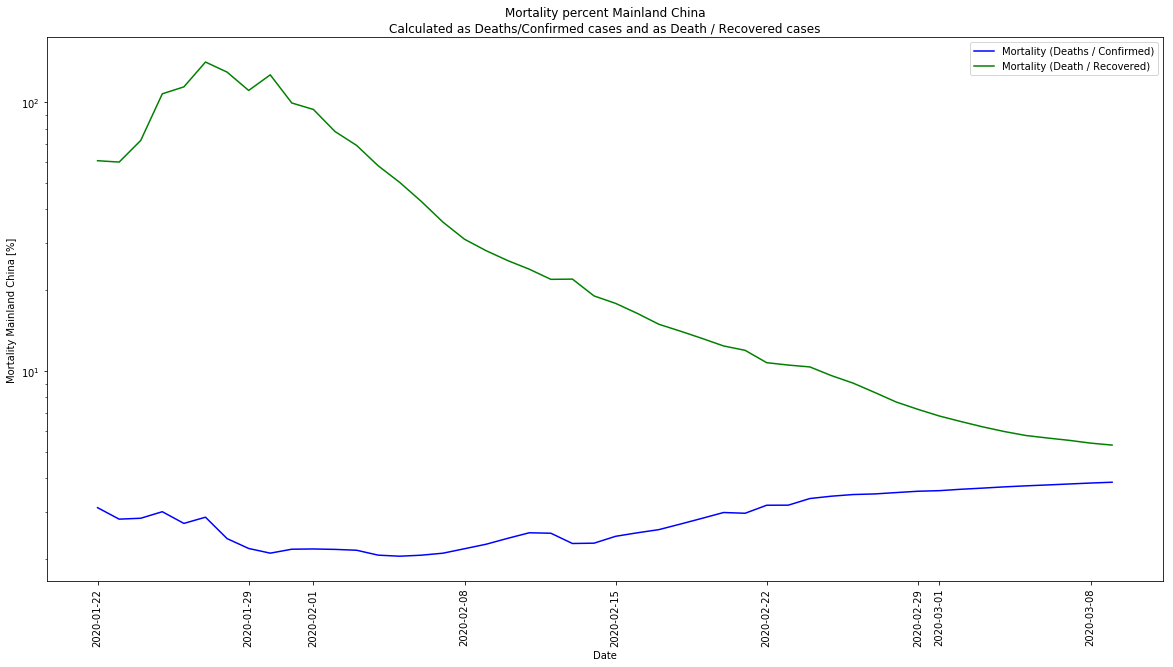

In [32]:
data_cn_agg['Mortality (D/C)'] = data_cn_agg['Deaths'] / data_cn_agg['Confirmed'] * 100
data_cn_agg['Mortality (D/R)'] = data_cn_agg['Deaths'] / data_cn_agg['Recovered'] * 100
plot_time_variation_mortality(data_cn_agg, size = 5)

We can observe that mortality calculated as Deaths / Confirmed cases oscilated constantly around 3% for Mainland China. The mortality calculated as Deaths / Recovered cases started high (since deaths were more prevalent that recoveries at start, especially because cases were discovered late and mostly the very severe). As the epidemics progressed and more and more measures to contains the spread were put in place, the percent of Deaths / Recovered droped. In the final, both calculations will converge to something that looks like around 3% for Mainland China.

# Rest of the world (not Mainland China)

Let's check now the status in the rest of the world. We eliminate the data from Mainland China.

In [33]:
data_wd = data_df.loc[~(data_df['Country/Region']=="Mainland China")]
data_wd = pd.DataFrame(data_wd.groupby(['Country/Region', 'Date'])['Confirmed', 'Recovered', 'Deaths'].sum()).reset_index()
data_wd.columns = ['Country', 'Date', 'Confirmed', 'Recovered', 'Deaths' ]
data_wd = data_wd.sort_values(by = ['Country','Date'], ascending=False)

In [34]:
data_ct = data_df.sort_values(by = ['Province/State','Date'], ascending=False)

data_ct = data_ct.sort_values(by = ['Country/Region','Date'], ascending=False)
data_ct = data_ct.loc[~(data_ct['Country/Region']=='Mainland China') & ~(data_ct['Country/Region']=='China')]
filtered_data_ct_last = data_ct.drop_duplicates(subset = ['Country/Region'],keep='first').reset_index()

filtered_data_ct_last = filtered_data_ct_last.loc[~filtered_data_ct_last.Latitude.isna()]
filtered_data_ct_last = filtered_data_ct_last.loc[~filtered_data_ct_last.Longitude.isna()]
filtered_data = pd.concat([filtered_data_last, filtered_data_ct_last], axis=0).reset_index()

data_ct_agg = data_ct.groupby(['Date']).sum().reset_index()

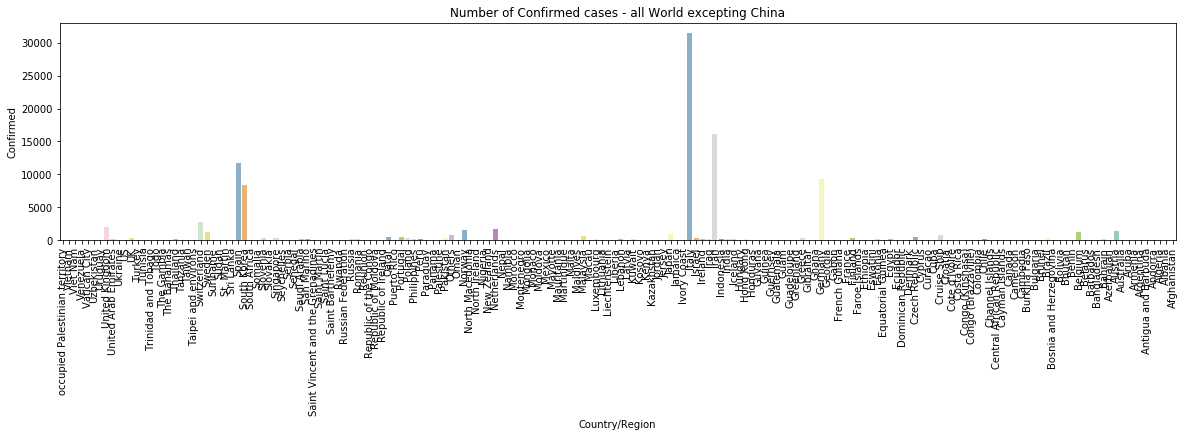

In [35]:
plot_count('Country/Region', 'Confirmed', 'Confirmed cases - all World excepting China', filtered_data_ct_last, size=5)

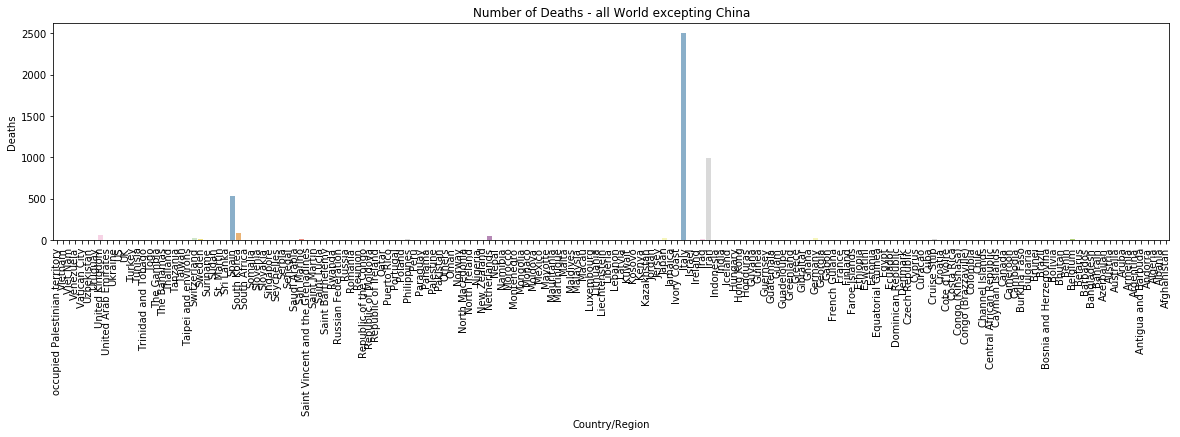

In [36]:
plot_count('Country/Region', 'Deaths', 'Deaths - all World excepting China', filtered_data_ct_last, size=5)

## Rest of the World (not Mainland China) - time variation

We show the time variation of Rest of the World cases (Confirmed, Recovered, Deaths).

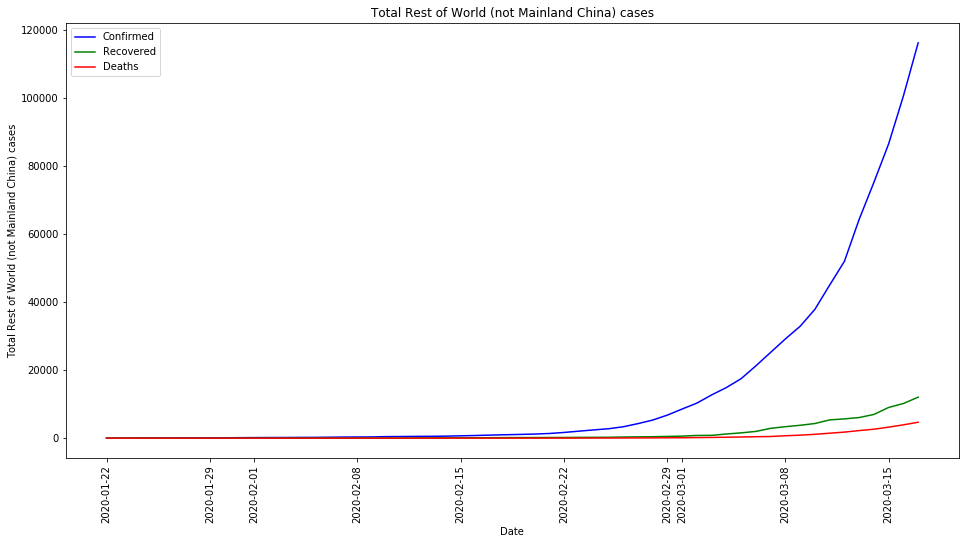

In [37]:
plot_time_variation_all(data_ct_agg, 'Rest of World (not Mainland China)', size=4)

Let's look separatelly to the dynamic of few countries.

In [38]:
data_select_agg = data_ct.groupby(['Country/Region', 'Date']).sum().reset_index()

In [39]:
def plot_time_variation_countries(df, countries, case_type='Confirmed', size=3):
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    for country in countries:
        df_ = df[(df['Country/Region']==country) & (df['Date'] > '2020-02-01')] 
        g = sns.lineplot(x="Date", y=case_type, data=df_,  label=country)
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    plt.show()  

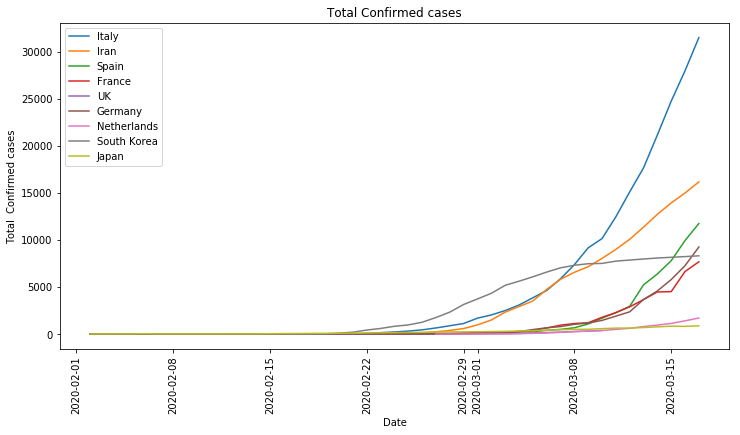

In [40]:
countries = ['Italy', 'Iran', 'Spain', 'France', 'UK', 'Germany','Netherlands', 'South Korea', 'Japan']
plot_time_variation_countries(data_select_agg, countries)

We can observe the very high dynamic in countries like Italy or Spain and the almost saturated curve in the case of South Korea.

## Rest of the World (not Mainland China) - Confirmed cases

In [41]:
filtered_wd_data_last = data_wd.drop_duplicates(subset = ['Country'],keep='first')

In [42]:
data_ct = data_df.sort_values(by = ['Province/State','Date'], ascending=False)
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'],keep='first').reset_index()

data_ct = data_ct.sort_values(by = ['Country/Region','Date'], ascending=False)
filtered_data_ct_last = data_ct.drop_duplicates(subset = ['Country/Region'],keep='first').reset_index()

filtered_data_ct_last = filtered_data_ct_last.loc[~filtered_data_ct_last.Latitude.isna()]
filtered_data_ct_last = filtered_data_ct_last.loc[~filtered_data_ct_last.Longitude.isna()]
filtered_data = pd.concat([filtered_data_last, filtered_data_ct_last], axis=0).reset_index()

data_ct_agg = data_ct.groupby(['Date']).sum().reset_index()


In [43]:
m = folium.Map(location=[0,0], zoom_start=2)
filtered_data_ct_last['Cnf'] = np.sqrt(filtered_data_ct_last['Confirmed'])
HeatMap(data=filtered_data_ct_last[['Latitude', 'Longitude', 'Cnf']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),\
        radius=30, max_zoom=12).add_to(m)
m

Note: US is not yet aggregated therefore is not showing on this map in its entire spread.

In [44]:
data_all_wd = pd.DataFrame(data_df.groupby(['Country/Region', 'Date'])['Confirmed',  'Recovered', 'Deaths'].sum()).reset_index()
data_all_wd.columns = ['Country', 'Date', 'Confirmed', 'Recovered', 'Deaths' ]
data_all_wd = data_all_wd.sort_values(by = ['Country','Date'], ascending=False)
filtered_all_wd_data_last = data_all_wd.drop_duplicates(subset = ['Country'],keep='first')
filtered_all_wd_data_last.loc[filtered_all_wd_data_last['Country']=='Mainland China', 'Country'] = 'China'
#filtered_all_wd_data_last

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Rest of the World (not Mainland China) mortality

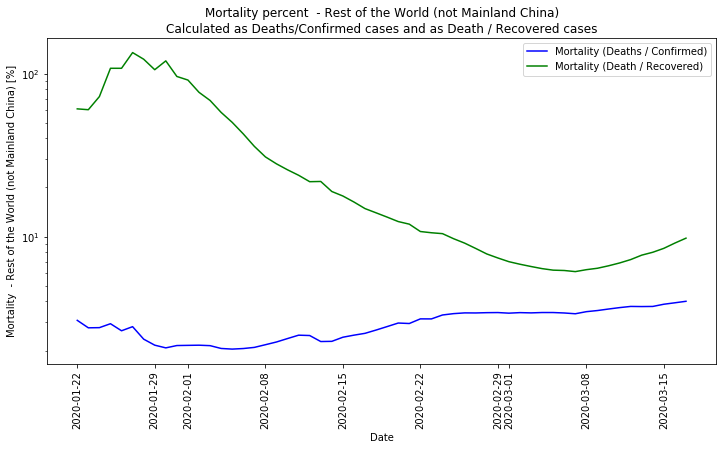

In [45]:
data_ct_agg = data_all_wd.groupby(['Date']).sum().reset_index()

data_ct_agg['Mortality (D/C)'] = data_ct_agg['Deaths'] / data_ct_agg['Confirmed'] * 100
data_ct_agg['Mortality (D/R)'] = data_ct_agg['Deaths'] / data_ct_agg['Recovered'] * 100
plot_time_variation_mortality(data_ct_agg, title = ' - Rest of the World (not Mainland China)', size = 3)

Mortality calculated as Deaths / Recovered is still increasing, as well as Deaths / Confirmed cases. This is mainly due to drastic increase in the number of Deaths in countries like Italy and Iran. Let's look separatelly to those countries.

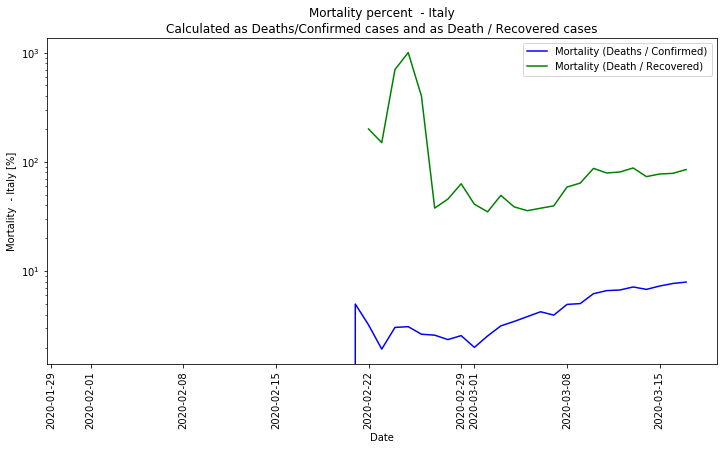

In [46]:
data_all_wd = pd.DataFrame(data_df.groupby(['Country/Region', 'Date'])['Confirmed',  'Recovered', 'Deaths'].sum()).reset_index()
data_all_wd.columns = ['Country', 'Date', 'Confirmed', 'Recovered', 'Deaths' ]
data_all_wd = data_all_wd.sort_values(by = ['Country','Date'], ascending=False)
data_italy = data_all_wd[data_all_wd['Country']=='Italy']
data_it_agg = data_italy.groupby(['Date']).sum().reset_index()

data_it_agg['Mortality (D/C)'] = data_it_agg['Deaths'] / data_it_agg['Confirmed'] * 100
data_it_agg['Mortality (D/R)'] = data_it_agg['Deaths'] / data_it_agg['Recovered'] * 100

plot_time_variation_mortality(data_it_agg, title = ' - Italy', size = 3)

The high mortality (and still raising) in Italy is most probably the result of delayed social isolation measures and also reluctance of the population to observe the rules. We see a raising pattern in both these ratios starting March 1st and it is likely for this pattern to continue since social isolation rules are slow to be enforced in this highly populated, with a large density of senior citizens, European country.

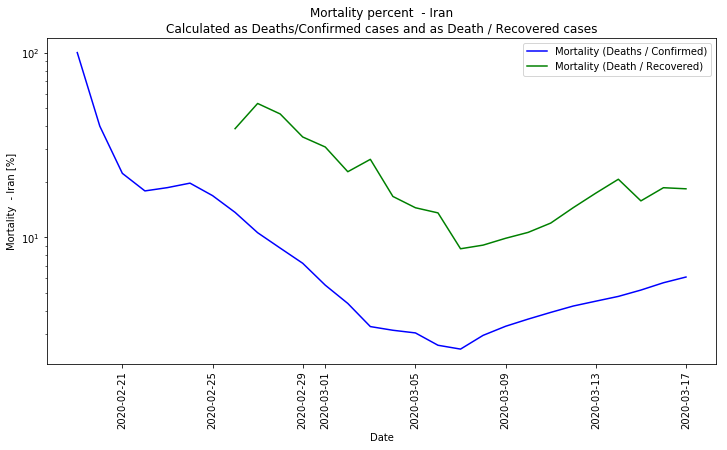

In [47]:
data_iran = data_all_wd[data_all_wd['Country']=='Iran']
data_ir_agg = data_iran.groupby(['Date']).sum().reset_index()

data_ir_agg['Mortality (D/C)'] = data_ir_agg['Deaths'] / data_ir_agg['Confirmed'] * 100
data_ir_agg['Mortality (D/R)'] = data_ir_agg['Deaths'] / data_ir_agg['Recovered'] * 100

plot_time_variation_mortality(data_ir_agg, title = ' - Iran', size = 3)

We can observe a strange pattern starting from March 7th, that seems to indicate a certain correlation between Confirmed and Recovered cases. Also in this case we can observe to increasing mortality rate by both metrics.



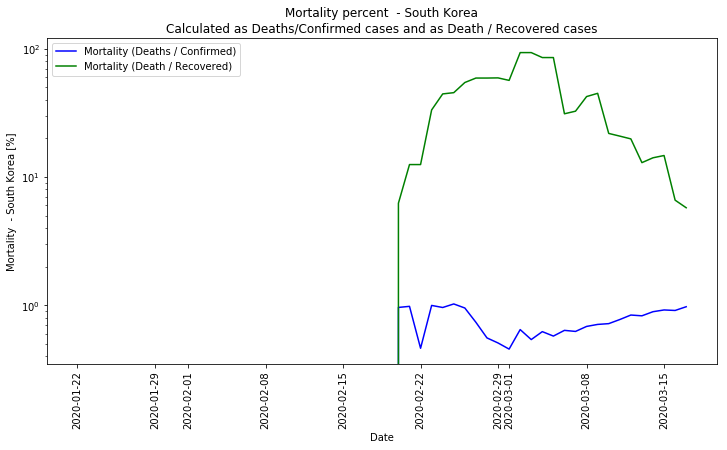

In [48]:
data_sk = data_all_wd[data_all_wd['Country']=='South Korea']
data_sk_agg = data_sk.groupby(['Date']).sum().reset_index()

data_sk_agg['Mortality (D/C)'] = data_sk_agg['Deaths'] / data_sk_agg['Confirmed'] * 100
data_sk_agg['Mortality (D/R)'] = data_sk_agg['Deaths'] / data_sk_agg['Recovered'] * 100

plot_time_variation_mortality(data_sk_agg, title = ' - South Korea', size = 3)

In South Korea preventive measures made possible initially to keep the ratio of Deaths to new Confirmed cases low (below 1%), while ratio of Deaths to Recovered cases is approaching now 10%. In recent days the number of death ratio to confirmed cases started to raise, approaching 1%.

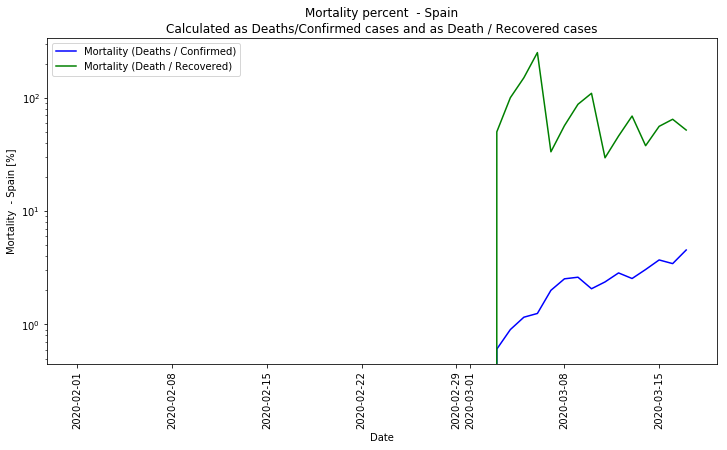

In [49]:
data_sp = data_all_wd[data_all_wd['Country']=='Spain']
data_sp_agg = data_sp.groupby(['Date']).sum().reset_index()

data_sp_agg['Mortality (D/C)'] = data_sp_agg['Deaths'] / data_sp_agg['Confirmed'] * 100
data_sp_agg['Mortality (D/R)'] = data_sp_agg['Deaths'] / data_sp_agg['Recovered'] * 100

plot_time_variation_mortality(data_sp_agg, title = ' - Spain', size = 3)

In Spain death ratio (calculated as number of deaths / confirmed cases) is above 2% is raising. Spain might be more than a week behind Italy in terms of evolution of epidemic.

# Predict evolution

Forecasting for fast-growing data is problematic. Let's try to forecast the evolution based on current development. We will try first to fit an exponential function on the data.

As each country is different, let's run this simulation for few different countries.

We will try to predict next few days (5 days).


In [50]:
import datetime
import scipy
def plot_exponential_fit_data(d_df, title, delta):
    d_df = d_df.sort_values(by=['Date'], ascending=True)
    d_df['x'] = np.arange(len(d_df)) + 1
    d_df['y'] = d_df['Confirmed']

    x = d_df['x'][:-delta]
    y = d_df['y'][:-delta]

    c2 = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(40, 0.1))
    #y = Ae^(Bx)
    A, B = c2[0]
    print(f'(y = Ae^(Bx)) A: {A}, B: {B}')
    x = range(1,d_df.shape[0] + 1)
    y_fit = A * np.exp(B * x)
    size = 3
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.scatterplot(x=d_df['x'][:-delta], y=d_df['y'][:-delta], label='Confirmed cases (included for fit)', color='red')
    g = sns.scatterplot(x=d_df['x'][-delta:], y=d_df['y'][-delta:], label='Confirmed cases (validation)', color='blue')
    g = sns.lineplot(x=x, y=y_fit, label='Predicted values', color='green')
    plt.xlabel('Days since first case')
    plt.ylabel(f'cases')
    plt.title(f'Confirmed cases & predicted evolution: {title}')
    plt.xticks(rotation=90)
    plt.show()


(y = Ae^(Bx)) A: 3.4497617223836454, B: 0.20010875802004963


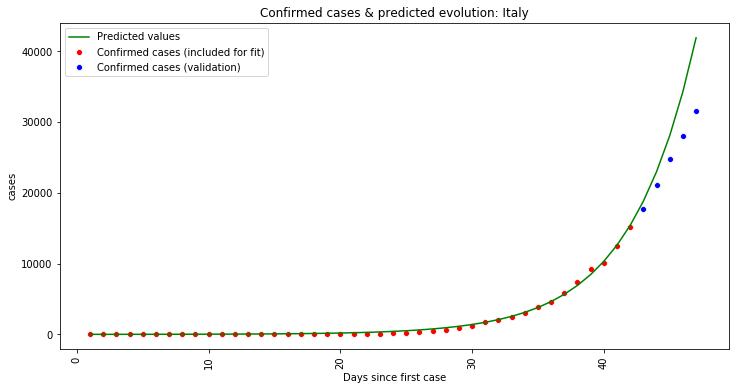

In [51]:
d_df = data_italy.copy()
plot_exponential_fit_data(d_df, 'Italy', 5)

Italy fits well to an exponential until day 35 after that hopefully the curve will decrease. 

(y = Ae^(Bx)) A: 45.393391561521256, B: 0.10537690719117448


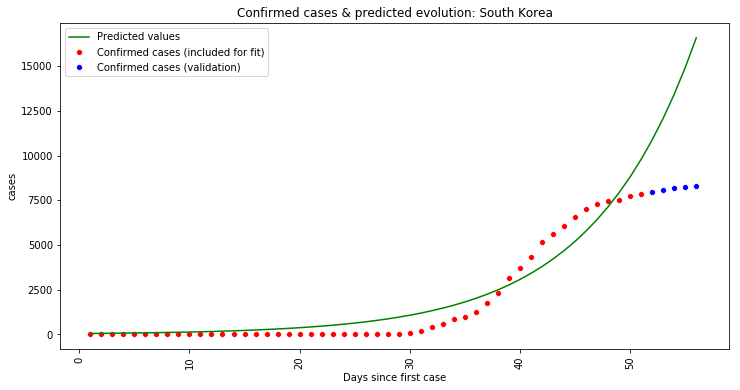

In [52]:
d_df = data_sk.copy()
plot_exponential_fit_data(d_df, 'South Korea', 5)

We can observe that an exponential fit is already not relevant for South Korea.  

Let's see also what happens in Spain.

(y = Ae^(Bx)) A: 0.0030424611329484654, B: 0.3369649288974966


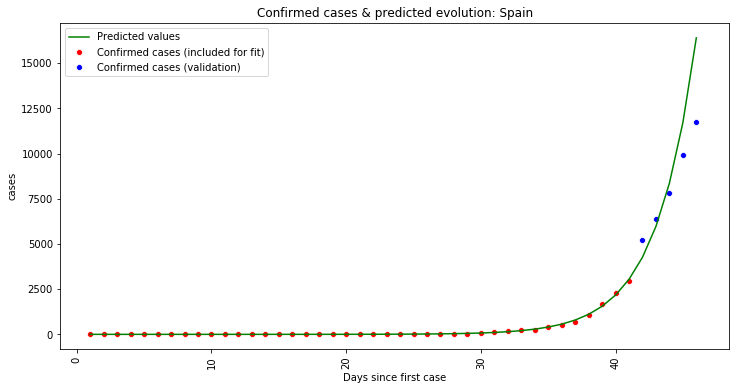

In [53]:
d_df = data_sp.copy()
plot_exponential_fit_data(d_df, 'Spain', 5)



Let's check as well Iran.

(y = Ae^(Bx)) A: 206.47268587647716, B: 0.1731696134211401


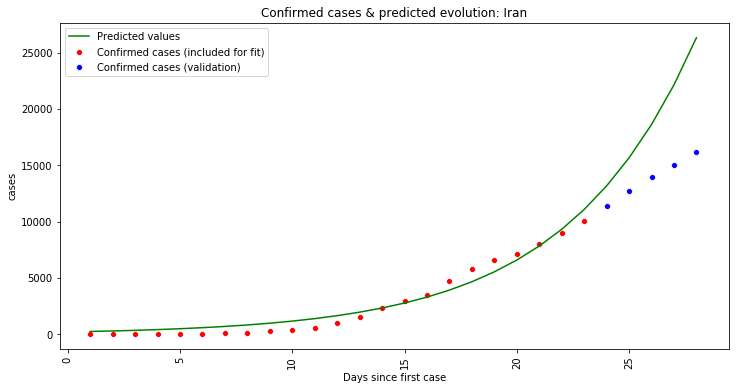

In [54]:
d_df = data_iran.copy()
plot_exponential_fit_data(d_df, 'Iran', 5)

Iran looks to have an inflection around day 15 but then a 2nd inflection around day 20 and is again slightly raising. It appears that the propagation is slower than in Italy, though.


## Romania

I am a Romanian, I will include here as well a graph with the number of cases in Romania.

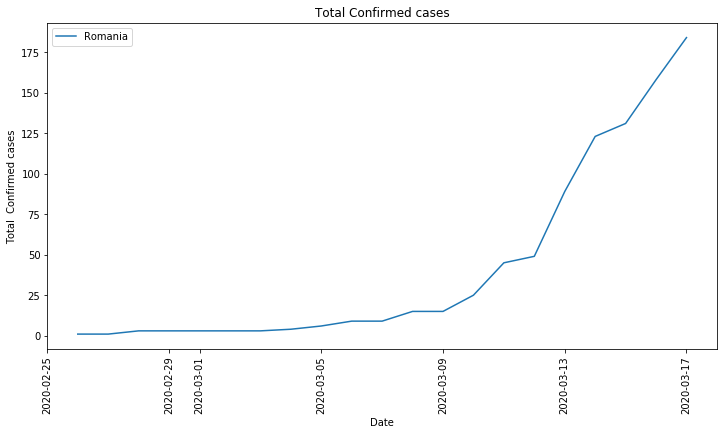

In [55]:
countries = ['Romania']
plot_time_variation_countries(data_select_agg, countries)

For Romania, where the dynamic is changing these days dramatically, we will only try to forecast for 3 days using this exponential curve fitting.

(y = Ae^(Bx)) A: 0.1355103641713049, B: 0.3785097116056995


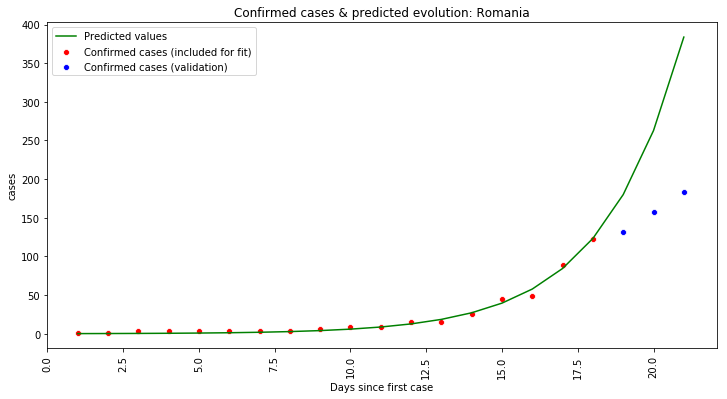

In [56]:
data_ro = data_all_wd[data_all_wd['Country']=='Romania']
d_df = data_ro.copy()
plot_exponential_fit_data(d_df, 'Romania', 3)

Let's try now to extrapolate this curve for another week.

In [57]:
def plot_exponential_fit_data_all_points(d_df, title, delta):
    d_df = d_df.sort_values(by=['Date'], ascending=True)
    d_df['x'] = np.arange(len(d_df)) + 1
    d_df['y'] = d_df['Confirmed']

    x = d_df['x']
    y = d_df['y']

    c2 = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(40, 0.1))
    #y = Ae^(Bx)
    A, B = c2[0]
    print(f'(y = Ae^(Bx)) A: {A}, B: {B}')
    x = range(1,d_df.shape[0] + delta)
    y_fit = A * np.exp(B * x)
    size = 3
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.scatterplot(x=d_df['x'], y=d_df['y'], label='Confirmed cases (included for fit)', color='red')
    g = sns.lineplot(x=x, y=y_fit, label='Predicted values', color='green')
    plt.xlabel('Days since first case')
    plt.ylabel(f'cases')
    plt.title(f'Confirmed cases & predicted evolution: {title}')
    plt.xticks(rotation=90)
    plt.show()

(y = Ae^(Bx)) A: 1.1898044702956403, B: 0.24386881794264972


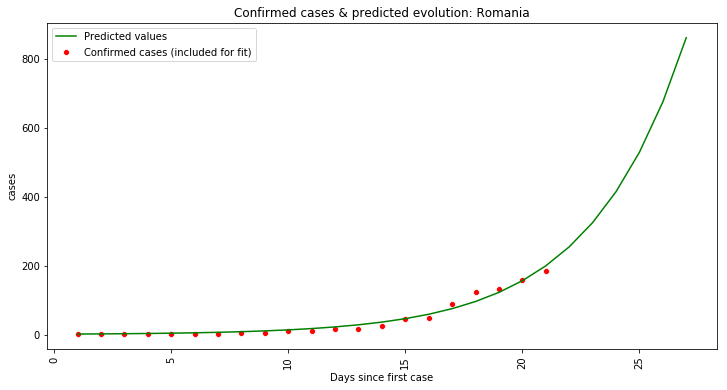

In [58]:
plot_exponential_fit_data_all_points(d_df, 'Romania', 7)

**2020-03-15**: Accounting for all available data now and using the same exponential curve fit, the forecast for one more week shows a total number of confirmed cases forecast in the 24th day since first case of ~1200.  

**2020-03-16**: Due to small increse on the day of 2020-03-15, this forecst based on exponential fit decreased to ~800 cases in 1 week.

**2020-03-17**: Due to small increse on the day of 2020-03-16, this forecst based on exponential fit is maintained to ~800 cases in 1 week. Looking to current development, the last few days the dynamic slowed a bit.

**2020-03-18**: Note: seems that data from John Hopkins is not updated with the latest developments from Romania.